<a href="https://colab.research.google.com/github/my612/Quantamania/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traveling Salesman Problem (TSP) Optimization

# 1. From Integer Linear Programming (ILP) to Quadratic Unconstrained Binary Optimization (QUBO)

## 1.1 ILP Problem Definition

### Problem Description

The Traveling Salesman Problem (TSP) is a classic optimization problem where the goal is to find the shortest possible route that visits each city exactly once and returns to the origin city. Given a set of cities and the distances between each pair of cities, the objective is to determine the optimal tour with the minimum total travel distance.

### MTZ Formulation

The Miller-Tucker-Zemlin (MTZ) formulation is a well-known Integer Linear Programming (ILP) approach to solve the TSP. It introduces additional variables to prevent subtours, ensuring a single contiguous tour.

### Variables

- $( x_{ij} )$: Binary variable indicating whether the path goes directly from city $( i )$ to city $( j )$.
- $( u_i )$: Auxiliary variable representing the order or rank of city $( i $) in the tour.

### Objective Function

Minimize the total travel distance:
$$
\text{minimize} \quad \sum_{i=1}^{n} \sum_{j=1}^{n} d_{ij} x_{ij}
$$
where $( d_{ij} )$ is the distance from city $( i $) to city $( j $).

### Constraints

1. **Outgoing arcs:**
   $$
   \sum_{j=1, j \neq i}^{n} x_{ij} = 1 \quad \forall i = 1, 2, \dots, n
   $$
2. **Incoming arcs:**
   $$
   \sum_{i=1, i \neq j}^{n} x_{ij} = 1 \quad \forall j = 1, 2, \dots, n
   $$
3. **Subtour elimination:**
   $$
   u_i - u_j + n x_{ij} \leq n - 1 \quad \forall i, j = 2, 3, \dots, n; i \neq j
   $$
4. **Variable bounds:**
   $$
   x_{ij} \in \{0, 1\} \quad \forall i, j = 1, 2, \dots, n; i \neq j
   $$
   $$
   u_i \in \mathbb{Z} \quad \forall i = 1, 2, \dots, n
   $$

### Assumptions

- Symmetric TSP: $( d_{ij} = d_{ji} $) for all $( i, j $).
- No self-loops: $( d_{ii} = 0 $) for all $( i $).

### Explanation

The MTZ formulation uses the auxiliary variables $( u_i $) to prevent subtours by enforcing an ordering on the cities. This ensures that the solution forms a single tour rather than multiple disconnected subtours.

This formulation is effective for solving the TSP and is widely used due to its simplicity and computational efficiency for moderate-sized instances.

## 1.2 Fromulating the problem using Qiskit's QuadraticProgram




In [ ]:
!pip install qiskit_optimization qiskit_algorithms
!pip install dimod
!pip install dwave-ocean-sdk

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
def TSP_as_ILP(dist_matrix, print_model = False):


  mod = QuadraticProgram("TSP")

  num_cities = len(dist_matrix)

  for i in range(num_cities):
      for j in range(num_cities):
          if i != j:
              mod.binary_var(f"x_{i}_{j}")
  for i in range(num_cities):
      mod.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'out_{i}')
      mod.linear_constraint(linear  ={f"x_{j}_{i}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'in_{i}')
  t = {}
  for i in range(num_cities):
      t[i] = mod.integer_var(lowerbound=0, upperbound=num_cities-1, name=f't_{i}')
  for i in range(1, num_cities):  # t_0 is fixed to 0, so start from i=1
      for j in range(1, num_cities):  # Ensure i != j
          if i != j:
              mod.linear_constraint(
                  linear={f"t_{j}": 1, f"t_{i}": -1, f"x_{i}_{j}": -(num_cities - 1)},
                  sense='>=',
                  rhs=1 - (num_cities - 1),
                  name=f"subtour_{i}_{j}"
              )
  obj = {}
  for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            obj[f"x_{i}_{j}"] = dist_matrix[i][j]
  mod.minimize(linear=obj)
  if print_model:
    print(mod.prettyprint())
  return mod


## 1.3 Conversion from ILP to QUBO


In [ ]:
def convert_ILP_to_QUBO(model, print_model = False):
    qubo = QuadraticProgramToQubo(penalty=350).convert(model)

    if print_model:
        print(qubo.prettyprint())

    return qubo

## 1.4 Using a specific instance of the problem.


Here we define functions to generate a sample distance matrix for the problem.

In [ ]:
def distance(a, b):
    """Calculates the Euclidean distance between two points."""
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def generate_data(n):
    """Generates a random set of n points and the distances between them."""
    coords = [(randrange(100), randrange(100)) for _ in range(n)]
    dists = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            dists[i][j] = dists[j][i] = distance(coords[i], coords[j])
    return dists, coords

In [ ]:
import math
from random import randrange

In [ ]:
dist_matrix, coord = generate_data(30)


In [ ]:

start = perf_counter()
model_quad = TSP_as_ILP(dist_matrix, print_model=False)

qubo = convert_ILP_to_QUBO(model_quad, print_model=False)

end = perf_counter()
variable_names = qubo.variables # Save Variables name to map them later
t = end - start
print(f"Time taken: {t} seconds")

Time taken: 14.411688195999886 seconds


# 2. Classical PuLP Solver for **TSP**

### 2.1 Implementing the TSP solver using PuLP

Install PuLP to solve the problem using integer linear programming,
and import the required libraries.

In [ ]:
!pip install pulp

In [ ]:
from pulp import *
import math
from random import randrange
import matplotlib.pyplot as plt
from itertools import pairwise, permutations
from time import perf_counter

Here we define a function to generate the ILP model for the problem given a distance matrix for the nodes, using the MTZ formulation shown previously.

In [ ]:
def create_model(dists):
    """MTZ formulation for TSP"""
    n = len(dists)
    tsp = LpProblem("TSP", LpMinimize)
    # x_ij denotes if there is directed edge from node i to node j
    x = LpVariable.dicts('x', [(i, j) for i in range(n) for j in range(n)], cat=LpBinary)
    # u_i represents the order/rank of node i
    u = LpVariable.dicts('u', range(n), 1, n, LpContinuous)

    # add the objective function
    tsp += lpSum(dists[i][j] * x[(i, j)] for i in range(n) for j in range(n))

    # add the constraints
    for i in range(n):
        tsp += x[(i, i)] == 0 # no loops
        tsp += lpSum(x[(i, j)] for j in range(n)) == 1 # outdegree == 1
        tsp += lpSum(x[(j, i)] for j in range(n)) == 1 # indegree == 1

    for i in range(n):
        for j in range(n):
            if i != j and i != 0 and j != 0:
                tsp += u[i] - u[j] + n*x[(i, j)] <= n - 1 # subtour elimination

    return tsp, x, u

Create some implementations to solve the TSP using brute force and backtracking techniques.

In [ ]:
def brute_force(dists):
    """Iterates over all possible routes to find the minimum. O(n!)"""
    n = len(dists)
    min_dist = math.inf
    min_route = None
    for route in permutations(range(1, n)):
        dist = 0
        u = 0
        for v in route:
            dist += dists[u][v]
            u = v
        dist += dists[u][0]
        if dist < min_dist:
            min_dist = dist
            min_route = route
    return min_dist, list(pairwise([0] + list(min_route) + [0]))

def _backtracking(dists, u, dist, route, min_dist, min_route):
    """
    Backtracking implementation.
    Also O(n!), but should be faster than the naive implementation.
    """
    if dist >= min_dist[0]:
        # if the current distance is not lower than the minimum
        # we have found so far, don't explore this route further.
        return

    n = len(dists)
    if len(route) == n:
        dist += dists[u][0]
        if dist < min_dist[0]:
            min_dist[0] = dist
            min_route[:] = route + [0]
        return

    for v in range(n):
        if v == u or v in route:
            continue
        route.append(v)
        _backtracking(dists, v, dist + dists[u][v], route, min_dist, min_route)
        route.pop()
    return
def backtracking(dists):
    dist, route = [math.inf], [] # hack for pass by reference in python
    _backtracking(dists, 0, 0, [0], dist, route)
    return dist, list(pairwise(route))

Generate a distance matrix with $n$ nodes, and create a function to plot the route we find.

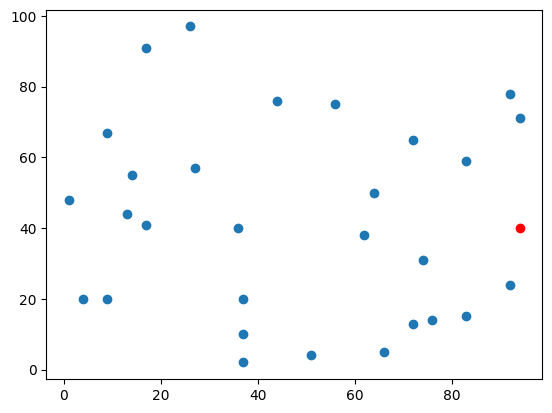

Time taken: 327.37856993700007 seconds


In [ ]:
n = 30

# dists, coords = generate_data(n)
dists = dist_matrix
# plot the points
coords = coord
plt.plot(coords[0][0], coords[0][1], 'ro')
plt.plot([p[0] for p in coords[1:]], [p[1] for p in coords[1:]], 'o')
plt.show()

def plot_route(route, coords):
    plt.plot(coords[0][0], coords[0][1], 'ro')
    for u, v in route:
        plt.plot([coords[u][0], coords[v][0]], [coords[u][1], coords[v][1]], 'b')

t = end - start
print(f"Time taken: {t} seconds")

Create and solve the ILP model, and plot the solution.

Optimal 451.55523139174323
Time taken: 14.200958965999234 seconds
[(0, 16), (1, 24), (2, 5), (3, 19), (4, 27), (5, 20), (6, 15), (7, 25), (8, 21), (9, 1), (10, 3), (11, 18), (12, 2), (13, 10), (14, 17), (15, 13), (16, 22), (17, 29), (18, 23), (19, 8), (20, 11), (21, 26), (22, 12), (23, 6), (24, 7), (25, 4), (26, 28), (27, 0), (28, 14), (29, 9)]


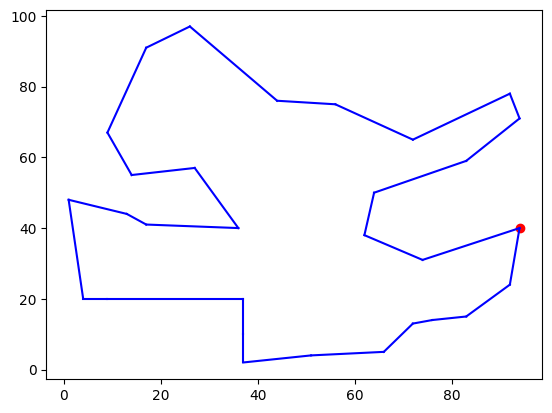

In [ ]:
start = perf_counter()
model, x, _ = create_model(dists)
status = model.solve()
print(LpStatus[status], pulp.value(model.objective))
route = [(i, j) for i in range(n) for j in range(n) if pulp.value(x[(i, j)]) == 1]
end = perf_counter()
t = end - start
print(f"Time taken: {t} seconds")
print(route)
plot_route(route, coords)

Solve the problem using other techniques.

In [ ]:
dist, route = backtracking(dists)
print(dist)
print(route)
plot_route(route, coords)

In [ ]:
dist, route = brute_force(dists)
print(dist)
print(route)
plot_route(route, coords)

We can see that the ILP solution is optimal because it matches that of the brute force implementation.

### 2.2 Analysis of Results

In [ ]:
samples = 3
N = 14
sizes = range(1, N)
problems = [(n, [generate_data(n)[0] for _ in range(samples)]) for n in sizes]

ilp_times = []
for n, dists in problems:
    total_time  = 0
    for dist in dists:
        start = perf_counter()
        model, x, _ = create_model(dist)
        status = model.solve()
        total_time += perf_counter() - start
    ilp_times.append(total_time / samples)

backtracking_times = []
for n, dists in problems:
    total_time  = 0
    for dist in dists:
        start = perf_counter()
        backtracking(dist)
        total_time += perf_counter() - start
    backtracking_times.append(total_time / samples)



plt.plot(sizes, [(1e3)*t for t in ilp_times], '-ro')
plt.plot(sizes, [(1e3)*t for t in backtracking_times], '-bo')
plt.xlabel("Number of nodes")
plt.ylabel("Time (ms)")
plt.show()

# 3. Exact Solver for QUBO Formulation

### 3.1 Exact Solver Approach


The Minimum Eigen Optimizer is a classical algorithm provided by Qiskit that leverages the NumPyMinimumEigensolver to find the exact solution to the QUBO problem. This solver is particularly useful for small-scale problems where an exact solution is feasible, as it avoids the exponential complexity of brute force methods.


### 3.2 Implementation and Testing


First, we import the necessary modules from Qiskit to use the MinimumEigenOptimizer and NumPyMinimumEigensolver. These tools allow us to solve the QUBO problem by finding the minimum eigenvalue of the corresponding Hamiltonian.

In [ ]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

Next, we use the MinimumEigenOptimizer to solve the QUBO model that we previously converted from the ILP formulation. The solver will return the optimal solution, which corresponds to the edges that minimizes the objective function.

In [ ]:
# define the solver to have the exact solution
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)

KeyboardInterrupt: 

In [ ]:
def interpret_result(solution):
  keys = [k for k, v in solution.items() if v == 1]
  edges = []
  for x in keys:
      _ = x.split("_")
      if _[0] == "x":
          i, j = int(_[1]), int(_[2])
          edges.append((i, j))
  return edges

Then we interpret the result to draw the route given by the exact solver.

In [ ]:
edges = interpret_result(result.variables_dict)
plot_route(edges, coords)
cost = result.fval
print(cost)

### 3.3 Advantages of the Minimum Eigen Optimizer
The MinimumEigenOptimizer offers several advantages over brute force methods:

**Exact Solution:** It guarantees the exact solution for small-scale problems.

**Efficiency:** It avoids the exponential complexity of brute force methods, making it more efficient for problems where the exact solution is feasible.

**Integration with Qiskit:** It seamlessly integrates with other Qiskit tools, allowing for easy comparison with quantum algorithms.




### 3.4 Limitations

Even when using a classical solver like the NumPyMinimumEigensolver, the problem remains framed in terms of qubits because the Hamiltonian is constructed using Pauli operators, which are inherently tied to qubit-based systems. This design ensures that the same framework can be used for both classical and quantum solvers, maintaining compatibility with quantum algorithms when necessary. However, this qubit-based representation becomes a limitation for large-scale instances. As the problem size grows, the number of qubits required increases exponentially, making the classical solver computationally infeasible due to the exponential growth of the solution space. This is why, for large instances, quantum or heuristic methods are often preferred, as they can potentially handle the complexity more efficiently.


# 4. Quantum Annealing Simulators to solve the QUBO

Quantum annealing is a heuristic optimization technique that leverages quantum mechanics to find the global minimum of a given objective function. In the context of the Traveling Salesman Problem (TSP), quantum annealing can be used to solve the QUBO formulation by exploring the energy landscape of the problem and finding the configuration of variables that minimizes the objective function.

### 4.1 Setting up the Quantum Annealing Simulator

To implement quantum annealing, we will use the D-Wave Ocean SDK, which provides tools for formulating and solving QUBO problems on quantum annealers. The first step is to import the necessary modules and set up the D-Wave system.

In [ ]:
from dwave.samplers import SimulatedAnnealingSampler
from dimod import BinaryQuadraticModel

Then create a sampler instance.

In [ ]:
sampler = SimulatedAnnealingSampler() # D-Wave Quantuam Sampler

Next, we need to convert the QUBO model into a format that can be processed by the D-Wave quantum annealer. This involves creating a BinaryQuadraticModel (BQM) from the QUBO coefficients.



In [ ]:
#Break Down the Qiskit QUBO to its components

qubo_dict = qubo.objective.quadratic.to_dict()
linear = qubo.objective.linear.to_dict()
offset = qubo.objective.constant

#Convert To D-Wave BQM
bqm = BinaryQuadraticModel(linear, qubo_dict, offset, 'BINARY')

### 4.2 Solving TSP Instances


After running the quantum annealer, we can extract the best solution from the response. The solution will be a binary vector that represents the optimal route for the TSP.

In [ ]:
start = perf_counter()
sampleset = sampler.sample(bqm, num_reads=1000)
best_solution = sampleset.first.sample
end = perf_counter()
t = end - start
print(f"Time taken: {t} seconds")

Time taken: 327.37856993700007 seconds


Finally, we can map the binary solution back to the original problem variables to determine the optimal route and calculate the total distance.

In [ ]:
# Map integer keys to variable names
variable_mapping = {i: name for i, name in enumerate(variable_names)}
print("Variable Mapping:", variable_mapping)

# Example: Convert best_solution (integer keys) to variable names
best_solution_with_names = {variable_mapping[key]: value for key, value in best_solution.items() if key in variable_mapping}
print("Best Solution with Variable Names:", best_solution_with_names)
# Precompute active edges
active_edges = []
for var, value in best_solution_with_names.items():
    if value == 1 and var.name.startswith("x_"):  # Ensure it's an edge variable
        parts = var.name.split("_")  # Split the variable name into parts
        i = int(parts[1])       # Extract i
        j = int(parts[2])       # Extract j
        active_edges.append((i, j))
print("Active Edges:", active_edges)
sum = 0
for edge in active_edges:
  sum += dist_matrix[edge[0]][edge[1]]
print(sum)

Active Edges: [(0, 16), (1, 11), (1, 12), (1, 14), (1, 18), (1, 20), (1, 26), (1, 27), (2, 5), (2, 6), (2, 9), (2, 11), (2, 14), (2, 27), (2, 28), (3, 2), (3, 4), (3, 6), (3, 15), (3, 17), (3, 22), (3, 24), (3, 25), (4, 26), (4, 29), (5, 1), (5, 6), (5, 10), (5, 11), (5, 21), (6, 2), (6, 3), (6, 8), (6, 13), (6, 22), (7, 12), (7, 24), (7, 27), (7, 29), (8, 4), (8, 10), (8, 17), (9, 2), (9, 12), (9, 15), (9, 21), (10, 3), (10, 5), (10, 7), (11, 5), (11, 12), (11, 22), (12, 10), (12, 17), (13, 5), (13, 12), (13, 17), (13, 18), (14, 4), (14, 6), (14, 9), (14, 12), (14, 20), (15, 11), (15, 12), (15, 19), (15, 22), (15, 28), (16, 3), (16, 6), (16, 18), (16, 29), (17, 14), (17, 18), (17, 20), (17, 28), (18, 4), (18, 10), (18, 25), (19, 7), (19, 9), (19, 20), (19, 23), (19, 26), (19, 27), (20, 2), (20, 4), (20, 8), (20, 12), (20, 13), (20, 15), (20, 22), (20, 23), (21, 1), (21, 11), (21, 12), (21, 15), (21, 22), (22, 14), (22, 15), (22, 18), (22, 21), (22, 26), (23, 9), (23, 10), (23, 18), (2

To analyze the performance of the quantum annealing approach, we can compare the results obtained from the quantum annealer with the exact solution found using classical methods. This will help us understand the accuracy and efficiency of quantum annealing for solving the TSP.

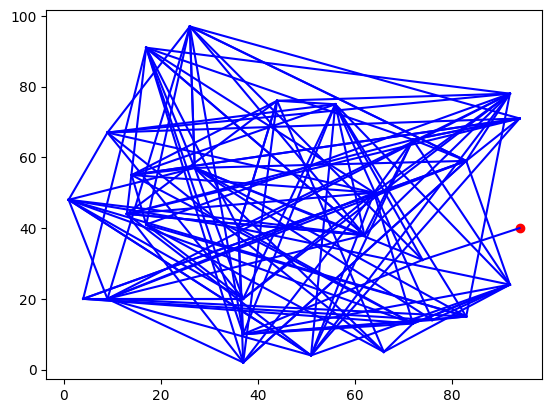

In [ ]:
plot_route(active_edges, coords)

### 4.3 Analysis of Quantum Annealing Results

To analyze the performance of the quantum annealing approach, we can compare the results obtained from the quantum annealer with the exact solution found using classical methods. This will help us understand the accuracy and efficiency of quantum annealing for solving the TSP.

# 5. Comparative Analysis and Conclusion

In [ ]:
#Break Down the Qiskit QUBO to its components
def create_BQM(dists):
    model_quad = TSP_as_ILP(dists, print_model=False)
    qubo = convert_ILP_to_QUBO(model_quad, print_model=False)
    variable_names = qubo.variables # Save Variables name to map them later

    quad = qubo.objective.quadratic.to_dict()
    linear = qubo.objective.linear.to_dict()
    offset = qubo.objective.constant

    #Convert To D-Wave BQM
    return BinaryQuadraticModel(linear, quad, offset, 'BINARY')

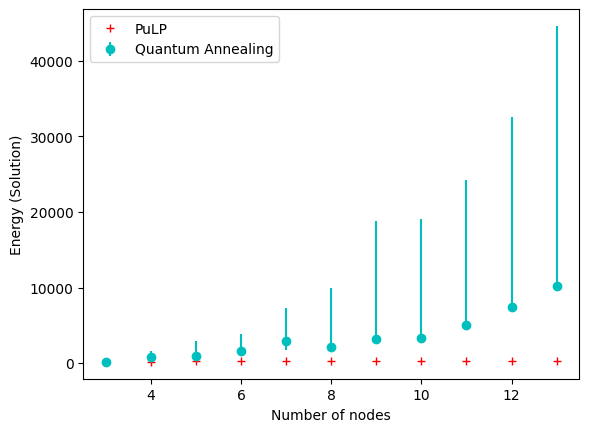

In [ ]:
x = range(3, 14)
bests = []
modes = []
worsts = []
pulp_data = []
for n in x:
    dists, coords = generate_data(n)
    bqm = create_BQM(dists)
    sampleset = sampler.sample(bqm, num_reads=1000)

    records = np.array([r.energy for r in sampleset.record])
    energies, counts = np.unique(records, return_counts=True)

    mode = energies[np.argmax(counts)]
    bests.append(mode - energies[0])
    modes.append(mode)
    worsts.append(energies[-1] - mode)

    model, _, _ = create_model(dists)
    status = model.solve()
    pulp_data.append(pulp.value(model.objective))

plt.errorbar(x, modes, yerr=[bests, worsts], fmt='co', label='Quantum Annealing')
plt.plot(x, pulp_data, 'r+', label="PuLP")
plt.legend(loc='upper left')
plt.xlabel("Number of nodes")
plt.ylabel("Energy (Solution)")
plt.show()

Comparing the optimal solutions from the classical solver with the quantum annealing, we observe that quantum annealing solutions fall behind as $n$ grows larger. Also that for larger values of $n$, quantum annealing fails to find a valid solution within the constraints, possibly due to falling into a local minimum in the energy landscape.

#### 5.1 Comparative Performance Analysis


#### 5.2 Conclusion
